In [34]:
import matplotlib
import numpy as np
from imageio import imread, imsave
from matplotlib import pyplot as plt 
%matplotlib inline

# 3.2 Dilation and Erosion

### Read RGB Image

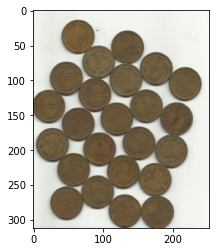

In [35]:
rgb_img = imread('W3LabData/coins.jpg')
plt.imshow(rgb_img)

### Convert RGB to Grayscale if necessary

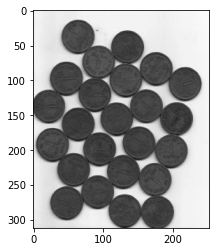

In [36]:
R = rgb_img[:,:,0]
G = rgb_img[:,:,1]
B = rgb_img[:,:,2]
# python supports matrix operation
gray_img = 0.212670 * R + 0.715160 * G + 0.072169 * B
gray_img = np.uint8(gray_img)
plt.imshow(gray_img, cmap='gray')

### Binary Thresholding

* Unique pixel values in gray_img: [ 31  37  38  39  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 253
 254]
* Unique pixel values in TF_matrix: [False  True]
* Unique pixel values in threshol

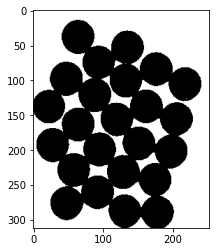

In [37]:
thresholdvalue = 127
TF_matrix = (gray_img > thresholdvalue) 
threshold = TF_matrix * 255
print('* Unique pixel values in gray_img:', np.unique(gray_img))
print('* Unique pixel values in TF_matrix:', np.unique(TF_matrix))
print('* Unique pixel values in threshold:', np.unique(threshold))
plt.imshow(threshold, cmap='gray')

### Determine foreground threshold

In [38]:
def convertWhiteAndBlack(img):
    return 255 - img

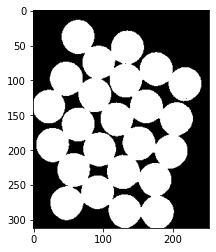

In [39]:
binary_img = np.array(convertWhiteAndBlack(threshold))
plt.imshow(binary_img, cmap='gray')

### Define structuring element

In [40]:
se = np.array([[1, 1, 1],
               [1, 1, 1],
               [1, 1, 1],])
print(se)

[[1 1 1]
 [1 1 1]
 [1 1 1]]


In [41]:
def preprocessing_padding_helper(img, kernel_size):
    pad_size = int(kernel_size / 2)
    # specify the pading for three dimensions
    # ((1,1), (1,1), (0,0)) => 1 padding for left and right, 
    #                          1 padding for top and bottom, 
    #                          no padding for color channels
    padding_2_dims = ((pad_size, pad_size), (pad_size, pad_size))
    img_padded = np.pad(img, padding_2_dims, 'constant', constant_values=0)
    print('*Padding: FROM ', img.shape,' TO ',img_padded.shape)
    return img_padded

### 3.2.1 Dilation - Grow (Thicken) - Bridging small breaks or gaps
Please refer to p17 of lecture slides for the algorithm of dilation:
https://canvas.sydney.edu.au/courses/17640/pages/week-2-lecture-morphological-image-processing-2?module_item_id=565513, your tutor will also show a short demo on how dilation works.

[ExtraReadingMaterial] https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm

In [67]:
def dilation(binary_img, SE):
    def dilation_helper(neighbour, SE):
        accumlator = 0
        for row_idx in range(SE.shape[0]):
            for col_idx in range(SE.shape[1]):
                if neighbour[row_idx][col_idx] * SE[row_idx][col_idx]:
                    return 1
        return 0
    if np.max(binary_img) == 255:
        binary_img = binary_img / 255
        
    binary_img_padded = preprocessing_padding_helper(binary_img, SE.shape[0])
        
    dilated_img = np.zeros(binary_img.shape)
    
    SE_size = SE.shape[0]
    pad_size = int(SE_size / 2)
    radius = int(SE_size / 2)
    height_max, width_max  = binary_img.shape
    for row_idx in range(height_max):
        for col_idx in range(width_max):
            ################  TODO  ################# 
            # examine the image pixel by pixel to determine
            # which pixels should be included in the dilated result
            padded_y_pos = row_idx + pad_size
            padded_x_pos = col_idx + pad_size
            
            init_x_pos = padded_x_pos - 1
            init_y_pos = padded_y_pos - 1
            end_x_pos = padded_x_pos + 1
            end_y_pos = padded_y_pos + 1
            
            neighbour = binary_img_padded[init_y_pos:end_y_pos + 1, init_x_pos:end_x_pos + 1]
            dilated_img[row_idx][col_idx] = dilation_helper(neighbour, SE)
            # print("{}x{} should be included in the dilated result".format(row_idx, col_idx))
    return np.array(dilated_img)

*Padding: FROM  (312, 252)  TO  (314, 254)
LEFT: Raw Image    RIGHT: Dilation


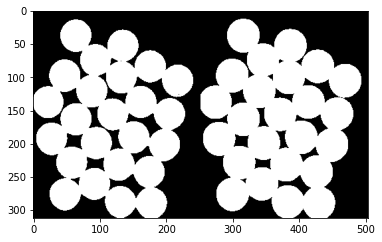

In [68]:
# Check the dilation effect against the original image
dilated_img = dilation(binary_img, se)
dilation_demo = np.concatenate((binary_img, dilated_img * 255),1)
print('LEFT: Raw Image    RIGHT: Dilation')
plt.imshow(dilation_demo, cmap='gray')

### *Application of Dilation : Boundary Detection

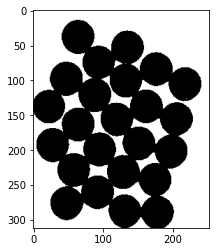

In [51]:
boundary = dilated_img * 255 - binary_img
plt.imshow(boundary, cmap='gray')

### 3.2.2 Erosion - Shrink (Thin) - Eliminate Noise
Please refer to p21 of lecture slides for the algorithm of dilation:
https://canvas.sydney.edu.au/courses/17640/pages/week-2-lecture-morphological-image-processing-2?module_item_id=565513, your tutor will also show a short demo on how erosion works.

[ExtraReadingMaterial] https://homepages.inf.ed.ac.uk/rbf/HIPR2/erode.htm

In [74]:
def erosion(binary_img, SE):
    def erosion_helper(neighbour, SE):
        for row_idx in range(SE.shape[0]):
            for col_idx in range(SE.shape[1]):
                if SE[row_idx][col_idx]:
                    if neighbour[row_idx][col_idx] * SE[row_idx][col_idx]:
                        pass
                    else:
                        return 0
        return 1
    if np.max(binary_img) == 255:
        binary_img = binary_img / 255
        
    binary_img_padded = preprocessing_padding_helper(binary_img, SE.shape[0])
    
    eroded_img = np.zeros(binary_img.shape)
    
    SE_size = SE.shape[0]
    pad_size = int(SE_size / 2)
    radius = int(SE_size / 2)

    height_max, width_max  = binary_img.shape
    # ignore the 1-pixel-width boundary (or belt) inside the raw_img, by putting constraints on the range.
    for row_idx in range (radius, height_max):
        for col_idx in range (radius, width_max):
            ################  TODO  ################# 
            # examine the image pixel by pixel to determine
            # which pixels should be included in the eroded result
            padded_y_pos = row_idx + pad_size
            padded_x_pos = col_idx + pad_size
            
            init_x_pos = padded_x_pos - 1
            init_y_pos = padded_y_pos - 1
            end_x_pos = padded_x_pos + 1
            end_y_pos = padded_y_pos + 1
            
            neighbour = binary_img_padded[init_y_pos:end_y_pos + 1, init_x_pos:end_x_pos + 1]
            eroded_img[row_idx][col_idx] = erosion_helper(neighbour, SE)
    return np.array(eroded_img)

*Padding: FROM  (312, 252)  TO  (314, 254)
LEFT: Raw Image    RIGHT: Erosion


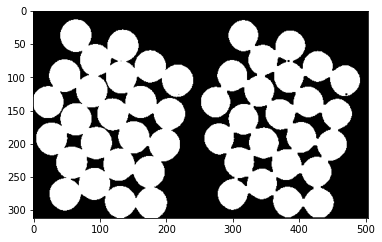

In [75]:
# Check the erosion effect against the original image
eroded_img = erosion(binary_img, se) 
print('LEFT: Raw Image    RIGHT: Erosion')
erosion_demo = np.concatenate((binary_img, eroded_img * 255),1)
plt.imshow(erosion_demo, cmap='gray')

### *Trick about Erosion
You can view erosion as a reversed version of Dilation which simply substitutes the positive and negative pixel values in this operation. In our case, assume dilation is to enlarge the regions with 255 to the regions with 0; erosion can be viewed as dilate regions with 0 to regions with 255.

*Padding: FROM  (312, 252)  TO  (314, 254)


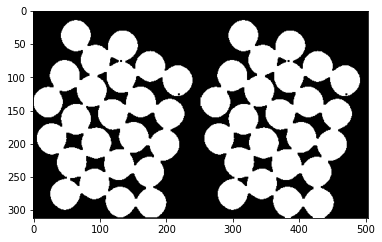

In [76]:
eroded_img_trick = 1 - dilation(convertWhiteAndBlack(binary_img), se)
demo_trick = np.concatenate((eroded_img * 255, eroded_img_trick * 255),1)
plt.imshow(demo_trick, cmap='gray')

### 3.2.3 Dilation and Erosion Implementation - Week3 Lab Exercise Submission
You can now use the generate_results() function below to generate your outputs for submission.

In [77]:
'''
    generate_results function is a helper function for you to generate
    the output images of lab exercise submission
    - Function Input: 
            -            wk:           int, indicates a specific week's lab exercise
            -          name:           str, the name of the student
            -           SID:           int, the SID of the student
            -       raw_img: numpy.ndarray, raw image
            -   output_imgs:          dict, stores the titles and outputs 
                                            as keys and values respectively.
                             i.e. you should store your outputs as {'[task name]':[numpy array],...}
                             
            -       channel:           int, the number of color channels
                             i.e. channel=1 indicates the images are grey images
                                  channel=3 indicates the images are RGB images
    - Function Usage:
            - Supply all the arguments with the correct types and a result image
              will be generated.
    - Tips:
            - You can right click the result image plot to save the image or 
              you can take a screenshoot for the submission.
'''
def generate_results(wk, name, SID, raw_img, output_imgs, channel):
    img_size = raw_img.shape
    x = img_size[0]
    y = img_size[1]
    
    # resize input image to a suitable size
    while x > 10:
        x /= (x / 10)
        y /= (y / 10)

    # Generate one axes each for the original image and all output images
    fig, axs = plt.subplots(1, len(output_imgs)+1, figsize=(x,y))
    
    # Plot the original image
    if channel == 1:
        axs[0].imshow(raw_img, cmap='gray')
    elif channel == 3:
        axs[0].imshow(raw_img)
    axs[0].text(0.5,-0.1, 'Original Image', size=12, ha="center", transform=axs[0].transAxes)
    axs[0].axis('off')
    
    # Plot each output image
    tasks = list(output_imgs.keys())
    for i in range(1,len(tasks)+1):
        if channel == 1:
            axs[i].imshow(output_imgs[tasks[i-1]], cmap='gray')
        elif channel == 3:
            axs[i].imshow(output_imgs[tasks[i-1]])
        axs[i].text(0.5,-0.1, tasks[i-1], size=12, ha="center", transform=axs[i].transAxes)
        axs[i].axis('off')

    fig.suptitle("Week %i Lab Exercise\n %s SID:%i"%(wk, name, SID),x=0.5,y=0.75)
    plt.tight_layout()
    plt.show()

*Padding: FROM  (312, 252)  TO  (314, 254)
*Padding: FROM  (312, 252)  TO  (314, 254)


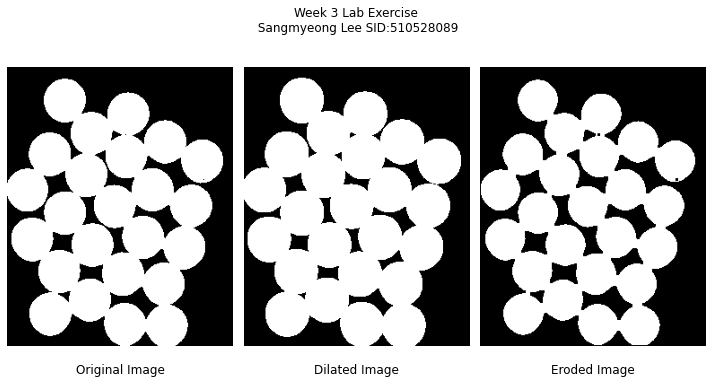

In [78]:
# Generate morphological processing results
dilated_img = dilation(binary_img, se) 
eroded_img = erosion(binary_img, se) 

# Now call generate_results() and provide the parameters as required
output_imgs = {'Dilated Image': dilated_img,
               'Eroded Image': eroded_img}
generate_results(3, 'Sangmyeong Lee', 510528089, binary_img, output_imgs,1)

## 3.3 Opening and Closing

### Opening - Smooth the Contour of Objects

In [ ]:
opened_img = dilation(erosion(binary_img, se) * 255, se) 
open_demo = np.concatenate((binary_img, opened_img * 255),1)
print('LEFT: Raw Image    RIGHT: Opening')
plt.imshow(open_demo, cmap='gray')

### Closing - Smooth the Contour of Objects

In [ ]:
closed_img = erosion(dilation(binary_img, se) * 255, se) 
close_demo = np.concatenate((binary_img, closed_img * 255),1)
print('1. Raw Image    2. Closing')
plt.imshow(close_demo, cmap='gray')

## 3.4 Evaluate Your Results

In [ ]:
demo = np.concatenate((binary_img, dilated_img * 255, eroded_img * 255, opened_img * 255, closed_img * 255),1)
print('1. Raw Image    2. Dilation  3. Erosion  4.Opening  5.Closing')
plt.imshow(demo, cmap='gray')

In [ ]:
# Evaluate your results by compraing them with the results generated
# by scipy or OpenCV2, please refer to the lab sheet for more details.
from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_opening, binary_closing # Evaluation purpose
import cv2